# Description:
In this notebook the thermal noise temperature is determined from the timetraces that are used to make up the transit curves in order to have a better thermal noise temperature estimate for simulation.

# Import modules:

In [1]:
from GalaxyFunctions import *
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from datetime import datetime
import scipy.fft as scfft

In [2]:
StNr,ChNr,CutOff,L=23,13,800,200
PDData=pd.read_pickle("./DSt23.pkl")[:L][["RunNr","EvNr","Unix"]]

In [3]:
# AvgFFT=np.zeros(2048,dtype="complex128")#np.empty((2048,0),dtype=object)
FFTs=np.empty((PDData[:L].shape[0],),dtype=object)
for idx,row in PDData[:L].iterrows():
    WaveFormFile=GetWaveformsFile(StNr,row["RunNr"])
    EventNrs=WaveFormFile['event_number'].array(library="np")
    EvIdx=np.where(EventNrs==row["EvNr"])[0][0]
    RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
    # HeaderFile=GetHeaderFile(StNr,Run)
    # TriggerTimes=HeaderFile["trigger_time"].array(library='np')
    #EvIdx=np.where(EventNrs==EvNr)[0][0]
    # RadiantData=WaveFormFile['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
    FFTs[idx]=np.abs(np.fft.fftshift(scfft.fft(ADCtoVoltage(RadiantData[0][ChNr]))))
    del RadiantData, EventNrs

In [4]:
AvgFFT=np.mean(FFTs,axis=0)
d = np.stack([Array for Array in FFTs])
MedFFT=np.median(d,axis=0)

In [5]:
PDData=PDData.assign(FFT=FFTs)

In [6]:
PDData.head()
PDData.loc[0,["FFT","RunNr"]]

FFT      [0.10073400000000099, 0.05209443963329, 0.0502...
RunNr                                                    1
Name: 0, dtype: object

In [7]:
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,2048*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)

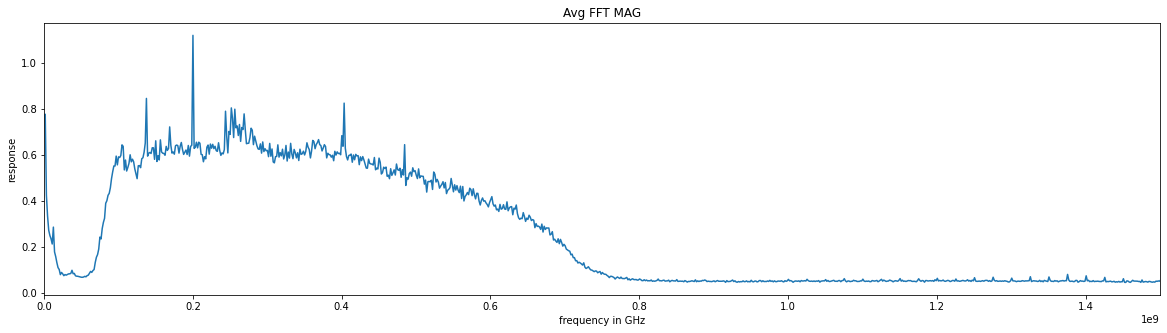

In [8]:
plt.figure(figsize=(20,5))
plt.plot(freq[int(len(freq)/2)+1:],AvgFFT[int(len(freq)/2)+1:],'-')#, label="Channel " + str(ChNr))
# plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Avg FFT MAG")
#plt.ylim(-50,50)
plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

In [9]:
TotalFilter=np.ones(len(freq))
TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,200*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
AvgFFT=np.array([AvgFFT[i]*TotalFilter[i] for i in range(len(freq))])
MedFFT=np.array([MedFFT[i]*TotalFilter[i] for i in range(len(freq))])

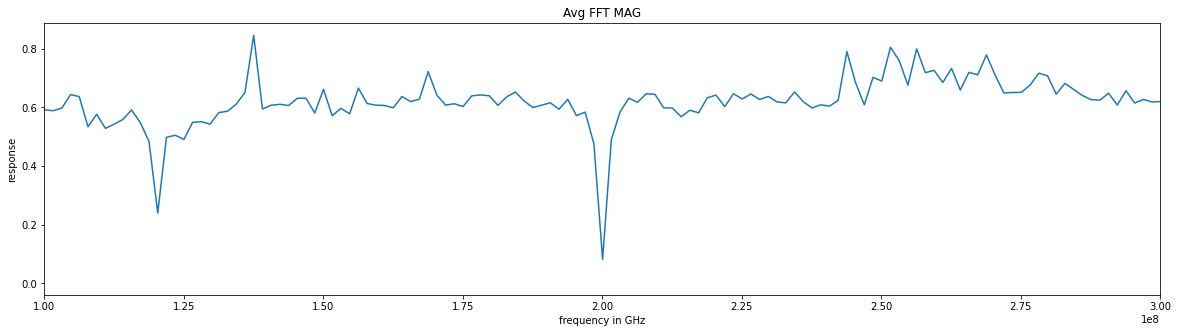

In [20]:
plt.figure(figsize=(20,5))
plt.plot(freq[int(len(freq)/2)+1:],AvgFFT[int(len(freq)/2)+1:],'-')#, label="Channel " + str(ChNr))
# plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Avg FFT MAG")
#plt.ylim(-50,50)
plt.xlim(0,1.5*1e9)
plt.xlim(0.1*1e9,0.3*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

In [11]:
Date=datetime.utcfromtimestamp(PDData["Unix"][0])# - timedelta(hours=2, minutes=0)
    
#Obtaining path to relevant json file for detector description
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2022.json"

#Defining the instances of classes necessary for the simulation
GNDetector = detector.Detector(json_filename = detpath)#,antenna_by_depth=False)
GNDetector.update(Date)

Amplifier type is: rno_surface
Freq range (GHz): [0.11880801 0.57371764]


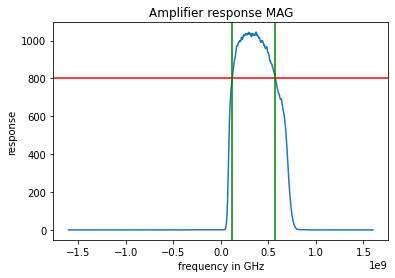

In [12]:
print("Amplifier type is: " + GNDetector.get_amplifier_type(StNr,ChNr))
ResponseMag=np.abs(GNDetector.get_amplifier_response(StNr, ChNr, freq*units.Hz))

Crossings = np.where(np.diff(np.sign(ResponseMag-CutOff)))[0]
print("Freq range (GHz):",freq[Crossings]*1e-9)
# Crossings = np.array([np.where(np.diff(np.sign(freq-0.12*1e9)))[0][0],np.where(np.diff(np.sign(freq-0.73*1e9)))[0][0]])
# print(freq)
# print(Crossings)
# print("Freq range (GHz):",freq[Crossings]*1e-9)

plt.figure()#figsize=(20,5))
plt.plot(freq,ResponseMag,'-')#, label="Channel " + str(ChNr))
plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("Amplifier response MAG")
#plt.ylim(-50,50)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

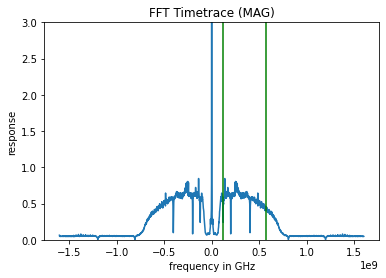

/ada_mnt/ada/user/jstoffels/software/RNOG_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


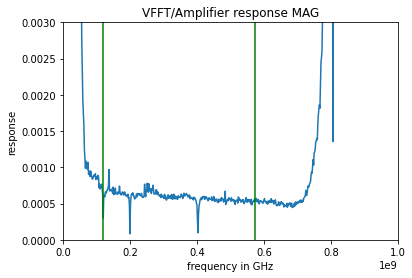

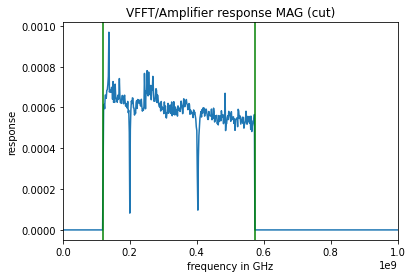

In [13]:
plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(AvgFFT),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("FFT Timetrace (MAG)")
plt.ylim(0,3)
#plt.xlim(0,1.5*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

# FFTD=np.array([FFT[i]/(ResponseMag[i]*(1400/np.max(ResponseMag))) if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])
FFTD=np.array([AvgFFT[i]/ResponseMag[i] if freq[Crossings][0]<freq[i]<freq[Crossings][-1] else 0 for i in range(len(freq))])

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(np.array([AvgFFT[i]/ResponseMag[i] for i in range(len(freq))])),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG")
plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(FFTD),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("VFFT/Amplifier response MAG (cut)")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1*1e9)
plt.ylabel("response")
plt.xlabel("frequency in GHz")
#plt.yscale('log')
#plt.legend()
plt.show()

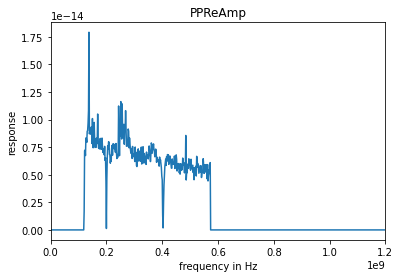

df: 454.9096238397655 MHz
Boltzmann cst: 1.38064852e-23
T: 311.4834766477172 K 
 38.33347664771725 C


In [14]:
R,k,df=50,1.38064852 * 1e-23,freq[Crossings][-1]-freq[Crossings][0]
PPreAmp=[((V*(2/len(SamplingTimes)))**2)/R for V in np.abs(FFTD) ]

plt.figure()#figsize=(20,5))
plt.plot(freq,np.abs(PPreAmp),'-')#, label="Channel " + str(ChNr))
#plt.axhline(y=CutOff, color='r', linestyle='-')
# plt.axvline(x=freq[Crossings][0], color='g', linestyle='-')
# plt.axvline(x=freq[Crossings][-1], color='g', linestyle='-')
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title("PPReAmp")
# plt.ylim(0,3*1e-3)
plt.xlim(0,1.2*1e9)
plt.ylabel("response")
plt.xlabel("frequency in Hz")
#plt.yscale('log')
#plt.legend()
plt.show()

Ptot=np.sum(np.abs(PPreAmp)) #Total power of the spectrum
# kb=1.38064852 * (10**(-23)) #Boltzmann constant
T=Ptot/(k*df)
print("df:",df/1e6,"MHz")
print("Boltzmann cst:",k)
print("T:",T,"K","\n",T-273.15,"C")

In [1]:
import time

print("Counting down:")
for i in range(10, 0, -1):
    print(i, end='\r')
    time.sleep(1)
print("Blast off!")

Counting down:
Blast off!
